### Base Operations

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import display
import copy

In [168]:
class Particle():
	def __init__(self, pos, E):
		self.pos = pos # list
		self.E = E
		
	def __copy__(self):
		return type(self)(self.pos, self.E)

class Lattice():
	
	def __init__(self, N):
		self.N = N
		self.lattice = np.zeros([self.N,self.N,2], dtype=bool)
		self.particles = []
		self.adjM = sp.sparse.lil_matrix((0,0), dtype=bool) # for interacting neighbours
	def __copy__(self):
		newL = type(self)(self.N, self.N_par)
		newL.lattice = copy.copy(self.lattice)
		newL.particles = copy.deepcopy(self.particles)
		newL.adjM = copy.copy(self.adjM)
		return newL

	def neiProcess(self, pos):
		# when looking for hopping places
		poss = np.array([[[[i,j,k] for i in range(-1,2)] for j in range(-1,2)] for k in range(-1,2)]).reshape(3,9,3).reshape(27,3)
		poss = pos + np.array([i for i in poss.tolist() if not np.array_equal(i,[0,0,0])])
		poss[0] = poss[0]%self.N
		poss[1] = poss[1]%self.N
		return poss

	def neiInteraction(self, pos):
		# neighbours for interaction, aka in a sublattice
		poss = np.array([[[i,j,0] for i in range(-1,2)] for j in range(-1,2)])
		poss = pos + np.array([i for i in poss.tolist() if not np.array_equal(i,[0,0,0])])
		poss[0] = poss[0]%self.N
		poss[1] = poss[1]%self.N
		return poss

	def addParticle(self, particle): # particle is Particle type
		tmp = self.adjM
		self.adjM = sp.sparse.lil_matrix((len(self.particles)+1,len(self.particles)+1), dtype=bool)
		self.adjM[:len(self.particles), :len(self.particles)] = tmp
		# new particles position in lattice
		lowest = list(self.lattice[*particle.pos, :]).index(False) # first unoccupied through z axis
		particle.pos = [*particle.pos, lowest] # now a 3D position
		self.lattice[*particle.pos] = True
		self.particles.append(particle)
		# adjacency matrix and neighbours
		for adj in self.neiInteraction(particle.pos):
			if self.lattice[*adj]:
				i = self.getParIndex(adj)
				self.adjM[-1, i] = True
				self.adjM[i, -1] = True

	def subParticle(self, index): # index in self.particles list
		ind = list(np.arange(len(self.particles), dtype=int))
		ind.pop(index)
		self.adjM = self.adjM[ind,:]
		self.adjM = self.adjM[:,ind]
		self.particles.pop(index)
		self.lattice[*self.particles[index].pos] = False
		
		  
	def getParIndex(self, pos):
		for j,p in enumerate(self.particles):
			if np.array_equal(p.pos, list(pos)):
				return j	
			
	def getNewPart(self, E_bound):
		# generating a random incoming particle with energy distribution of Maxwell-Boltzmann
		# and a random position with a uniform angular distribution assuming the slit of the effusion cell is really far away
		E = np.Inf
		while E < E_bound:
			E = sp.stats.gamma.rvs(1.5, loc=0, scale=1)  #  gamma.pdf(y, a) / scale    with    y = (x - loc) / scale
			pos = list(np.random.randint([self.N, self.N]))
		return Particle(pos, E)		# position still 2D

	def getRateFactors(self, T, E_bond, E_bound):
		# creating n_new by checking the viable neighbours of the neighbours of each particle
		occ_x,occ_y = np.where(self.lattice == True)
		occ_sites = [[x,y] for x,y in zip(occ_x,occ_y)]
		unocc_nextto_occ = [[site for site in self.neiProcess(occ) if (self.lattice[*site] == False and site[3] >= 0)] for occ in occ_sites]

		origin = []
		destination = []
		probability = []
		execution = []
		for o,d_collection in zip(occ_sites,unocc_nextto_occ):
			E_old = len(self.adjM[self.getParIndex(o)].nonzero()[0])*E_bond
			for d in d_collection:
				E_hop = sum([E_bond for site in self.neiInteraction(d) if self.lattice[*site] == True])
				origin += [o]
				destination += [d]
				'''differentiating between intra and interlayer jumping ??? '''
				if self.lattice[*(d + np.array([0,0,-1]))]: # hopping
					probability += [self.particles[o].E/T * np.exp((E_hop - E_old)/T)]
					execution += [0]
				else: # desorption
					probability += [self.particles[o].E/T * np.exp((E_bound - E_old)/T)]
					execution += [1]

		return origin, destination, probability, execution

	def doAProcess(self, T, E_bond, E_bound):
		# a single process in the lattice

		o, d, p, e = self.getRateFactors(T, E_bond, E_bound)
		# choosing a process proportional to the probability rates
		i = np.random.choice(np.arange(len(d)),p=p/np.sum(p))
		parIndex = self.getParIndex(o[i])

		'''Could be argued that a subParicle() and an addParticle() is more efficient?'''
		match e[i]:
			case 0: # hopping case
				# update lattice point
				self.lattice[*o[i]] = False
				self.lattice[*d[i]] = True
				# update particle position
				self.particles[parIndex].pos = d[i]
				# update adjacency matrix
				self.adjM[:,parIndex] = False
				self.adjM[parIndex,:] = False
				for adj in self.neiInteraction(d[i]):
					if self.lattice[*adj]:
						parNei = self.getParIndex(adj)
						self.adjM[parIndex,parNei] = True
						self.adjM[parNei,parIndex] = True		
			case 1: # desorption case
				self.subParticle(parIndex)

		# update particle energies
		self.correctHopEnergy(o[i], d[i], e[i], E_bond) # thermalization dependent on what happened

	def correctHopEnergy(self, origin, destination, execution, E_bond):
		# energy change/distribution upon hopping event

		# hopping particle is at destination
		# 1st: change energy based on bond structure (bond lost -> energy gained)
		# 	origin: (always)
		for particle_pos in self.neiInteraction(origin):
			if self.lattice[*particle_pos] == True and not np.array_equal(destination,particle_pos): # occ and not hopping particle (avoid extra "self" interaction)
				# neighboring lose one bond only while hopping (temporarly) lose all bonds
				self.particles[self.getParIndex(particle_pos)].E += E_bond	# neighboring particles
				self.particles[self.getParIndex(destination)].E += E_bond	# hopping particle
		# 	destination: (only if particle is not desorped) (bond created -> energy lost)
		# 		in case of desorption rest of the process is not defined -> return early from energy handling
		if execution == 1: # desorption
			return
		for particle_pos in self.neiInteraction(destination):
			if self.lattice[*particle_pos] == True:
				self.particles[self.getParIndex(particle_pos)].E -= E_bond	# neighboring particles
				self.particles[self.getParIndex(destination)].E -= E_bond	# hopping particle
		# 2nd: redistribute energy between particles around destination
		particles_affected_pos = [pos for pos in self.neiInteraction(destination) if self.lattice[*pos] == True] + [destination]
		E_mean = np.mean([self.particles[self.getParIndex(pos)].E for pos in particles_affected_pos])
		E_sum_abs_deviation_from_mean = np.sum([np.abs(E_mean-self.particles[self.getParIndex(pos)].E) for pos in particles_affected_pos])
		for particle_pos in particles_affected_pos:
			self.particles[self.getParIndex(particle_pos)].E += E_mean*(E_mean-self.particles[self.getParIndex(particle_pos)].E)/E_sum_abs_deviation_from_mean
		# done :)


	def processSequence(self, N_process=1, T=1, E_bond=1, E_bound=2):
		# repeated processes, introducing new particles

		N_particles = int(N_process/10)
		queueParticle = np.random.randint(5, 10, int(N_process/10))
		n = 0
		for action in range(N_process):
			if action%sum(queueParticle[:n]) == 0:
				n += 1
				self.addParticle(self.getNewPart(E_bound))
			self.doAProcess(T, E_bond, E_bound)
		'''
		NEEDED!!!
		Expanding the layers, handling active layers
		Animation and stuff, physical properties if you want
		Best would be if we can visualize by color the energies of particles besides the position

		
		https://matplotlib.org/stable/users/explain/animations/animations.html
		'''


	def plot(self):
		xv, yv = np.meshgrid(np.arange(self.N, dtype=float), np.arange(self.N, dtype=float))
		xv[1:self.N:2, :] += 0.5
		xl = []; yl = []
		for i,p in enumerate(self.particles):
			if p.pos[1]%2 == 1:
				xl.append(p.pos[0]+0.5)
			else:
				xl.append(p.pos[0])
			yl.append(p.pos[1])
			# plt.annotate(str(i), (xl[-1], yl[-1]))
		plt.scatter(xv, yv, c='b')
		plt.scatter(xl, yl, c='r')
		plt.show()



In [156]:
# TESTING SITE
x, y, z = np.meshgrid(np.arange(1,5),np.arange(1,4),np.arange(1,3))
a = x * y * z

a = np.where(np.random.rand(4,4,4) < 0.5, True, False)
display(a)
display(list(a[2,1,:]))
list(a[2,1,:]).index(False)

array([[[ True,  True, False,  True],
        [False,  True,  True,  True],
        [False,  True, False,  True],
        [ True, False,  True, False]],

       [[ True, False, False,  True],
        [ True, False, False, False],
        [ True, False, False,  True],
        [False, False,  True,  True]],

       [[False,  True,  True,  True],
        [ True,  True, False, False],
        [ True, False,  True, False],
        [ True,  True,  True,  True]],

       [[ True,  True,  True, False],
        [ True, False, False,  True],
        [False,  True,  True, False],
        [False,  True,  True, False]]])

[True, True, False, False]

2

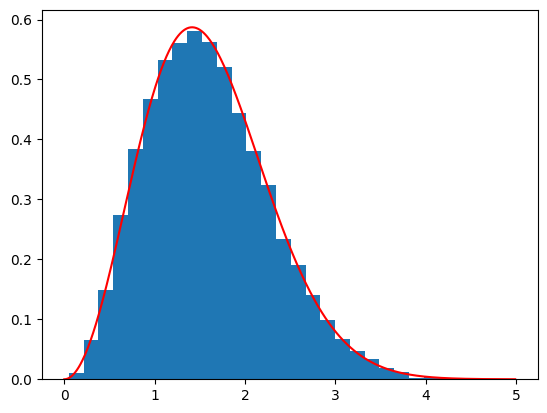

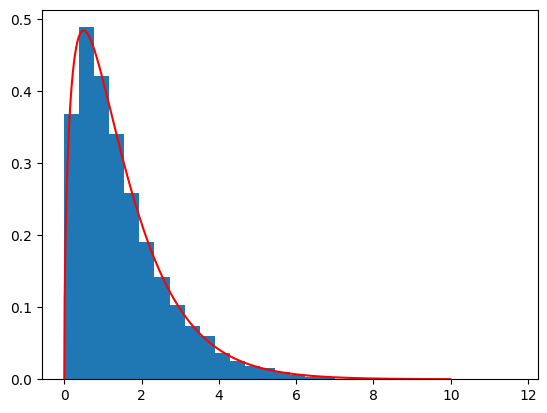

In [42]:
plt.hist(sp.stats.maxwell.rvs(size=10000, loc=0, scale=1), 30, density=True)
plt.plot(np.arange(0,5,1e-2), sp.stats.maxwell.pdf(np.arange(0,5,1e-2)), 'r-')
plt.show()

plt.hist(sp.stats.gamma.rvs(1.5, size=10000, loc=0, scale=1), 30, density=True)
plt.plot(np.arange(0,10,1e-2), sp.stats.gamma.pdf(np.arange(0,10,1e-2), 1.5, scale=1), 'r-')
# plt.xlim([0, 10])
plt.show()


In [ ]:
def gridFreezing(N, N_par, N_hop, T):
    # input is either fixed T and number of hops
    # or a T array with arbitrary N_hops
    lattice = TriangleLattice(N, N_par)
    lattice.fillParticle()
    lattice.plot()
    lattice_var = copy.copy(lattice)

    # comparisons
    print("Varying T while iterating")
    lattice.hoppingSequence(N_hop, T)
    # print("Steady T while iterating")
    # lattice_var.hoppingSequence(N_hop)

N = 40 # lattice grid size, even number
N_par = 400 # particles on the grid
N_hop = 1000 # number of hoppings to occur
T = 1/(np.linspace(0.1, 10, N_hop)) # freezing in terms of rates (rates increase for high neighbours)

gridFreezing(N, N_par, N_hop, T)

In [3]:
a=np.array([[0,0],[0,0]])
print(a,a.shape)
a=np.expand_dims(a,axis=2)
print(a,a.shape)
b=np.append(a,a,axis=2)
print(b,b.shape)
b=np.append(b,a,axis=2)
print(b,b.shape)

[8, 9]

In [12]:
a=np.arange(9).reshape((3,3))
print(a)
b=np.array([1,1,5])
print(a[1,1])
print(a[*b[:2]])
print(b[:2])

[[0 1 2]
 [3 4 5]
 [6 7 8]]
4
4
[1 1]


In [26]:
a=np.array([2,2])
b=np.zeros(a)
c=np.zeros_like(b,dtype=bool)
np.zeros_like(c)

array([[False, False],
       [False, False]])

In [29]:
a=np.array([[1,1,1],[10,10,10]])
a[:,0]%=4
print(a)
np.append(a,a,axis=0)

[[ 1  1  1]
 [ 2 10 10]]


array([[ 1,  1,  1],
       [ 2, 10, 10],
       [ 1,  1,  1],
       [ 2, 10, 10]])

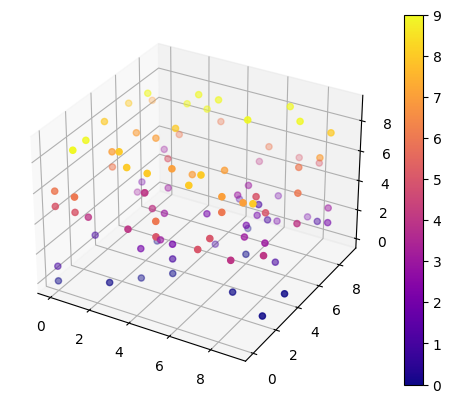

In [68]:
from matplotlib import pyplot as plt
from celluloid import Camera
import random

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_vals = list(range(0, 10))
y_vals = list(range(0, 10))
z_vals = list(range(0, 10))

camera = Camera(fig)
for i in range(10):
    random.shuffle(x_vals)
    random.shuffle(y_vals)
    random.shuffle(z_vals)

    scat = ax.scatter(x_vals, y_vals, z_vals, c=z_vals, cmap='plasma')
    
fig.colorbar(scat)

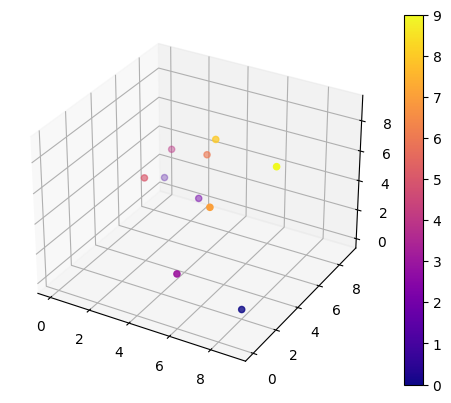

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import random

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_vals = list(range(0, 10))
y_vals = list(range(0, 10))
z_vals = list(range(0, 10))

random.shuffle(x_vals)
random.shuffle(y_vals)
random.shuffle(z_vals)

scat = ax.scatter(x_vals, y_vals, z_vals, s=np.array(z_vals)*10, c=z_vals, cmap='plasma')
fig.colorbar(scat)
plt.show()
